In [1]:
from scivision import default_catalog, load_pretrained_model, load_dataset

In [2]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == "huggingface-object-detection"].url.item()
model_repo # Why not paste the repo link into your browser and see how it looks?

AnyUrl('https://github.com/alan-turing-institute/scivision_huggingface_objectdetection', scheme='https', host='github.com', tld='com', host_type='domain', path='/alan-turing-institute/scivision_huggingface_objectdetection')

In [3]:
facebook_model = load_pretrained_model(model_repo, model='facebook_detr_resnet_50', allow_install="force")

  Cloning https://github.com/alan-turing-institute/scivision_huggingface_objectdetection (to revision main) to /private/var/folders/kf/72snt1z56h56smb3y7c0dxpr9rwb6q/T/pip-install-k5li2__o/huggingface-objectdetection_aa1be955ea3c44bcb396e04931671165


  Running command git clone --filter=blob:none --quiet https://github.com/alan-turing-institute/scivision_huggingface_objectdetection /private/var/folders/kf/72snt1z56h56smb3y7c0dxpr9rwb6q/T/pip-install-k5li2__o/huggingface-objectdetection_aa1be955ea3c44bcb396e04931671165


  Resolved https://github.com/alan-turing-institute/scivision_huggingface_objectdetection to commit 9e92ce06e2e938f810ee00fc106daa4a63ee3cf7
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.2/205.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.4/588.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.7/961.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setu

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=5a62cb51c5aabd00dbd2ca0c356e4e8938af3b6a7c287c85017b82e9fc1d4b87
  Stored in directory: /private/var/folders/kf/72snt1z56h56smb3y7c0dxpr9rwb6q/T/pip-ephem-wheel-cache-qczbf7cv/wheels/b6/0d/90/0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built huggingface_objectdetection jax mplcursors cairocffi termcolor
  Attempting uninstall: webencodings
    Found existing installation: webencodings 0.5.1
    Uninstalling webencodings-0.5.1:
      Successfully uninstalled webencodings-0.5.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: termcolor
    Found existing installation: termcolor 1.1.0
    Uninstalling termcolor-1.1.0:
      Successfully uninstalled termcolor-1.1.0
  Attempting uninstall: tensorboard-plugin-wit
    Found existing installa

  Attempting uninstall: kiwisolver
    Found existing installation: kiwisolver 1.4.2
    Uninstalling kiwisolver-1.4.2:
      Successfully uninstalled kiwisolver-1.4.2
  Attempting uninstall: jarowinkler
    Found existing installation: jarowinkler 1.0.2
    Uninstalling jarowinkler-1.0.2:
      Successfully uninstalled jarowinkler-1.0.2
  Attempting uninstall: idna
    Found existing installation: idna 3.3
    Uninstalling idna-3.3:
      Successfully uninstalled idna-3.3
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: filelock
    Found existing installation: filelock 3.7.0
    Uninstalling filelock-3.7.0:
      Successfully uninstalled filelock-3.7.0
  Attempting uninstall: defusedxml
    Found existing installation: defusedxml 0.7.1
    Uninstalling defusedxml-0.7.1:
      Successfully uninstalled defusedxml-0.7.1
  Attempting uninstall: cycler
    Found existing 

    Uninstalling tensorflow-cpu-2.9.1:
      Successfully uninstalled tensorflow-cpu-2.9.1
  Attempting uninstall: python-doctr
    Found existing installation: python-doctr 0.5.1
    Uninstalling python-doctr-0.5.1:
      Successfully uninstalled python-doctr-0.5.1
  Attempting uninstall: flax
    Found existing installation: flax 0.5.0
    Uninstalling flax-0.5.0:
      Successfully uninstalled flax-0.5.0
  Attempting uninstall: huggingface_objectdetection
    Found existing installation: huggingface-objectdetection 0.0.1
    Uninstalling huggingface-objectdetection-0.0.1:
      Successfully uninstalled huggingface-objectdetection-0.0.1


In [4]:
yolo_model = load_pretrained_model(model_repo, model='hustvl_yolos_tiny')

INFO:scivision.koala:Call='load_pretrained_model', module='scivision.io.reader', signature=(path: os.PathLike, branch: str = 'main', allow_install: bool = False, model: str = 'default', load_multiple: bool = False, *args, **kwargs) -> scivision.io.wrapper.PretrainedModel, kwargs_given='model'


In [5]:
compatible_datasources = default_catalog.compatible_datasources("huggingface-object-detection").to_dataframe()
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Koala,"(TaskEnum.object_detection, TaskEnum.classific...","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"


In [6]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-003']
target_datasource

,name,description,tasks,domains,url,format,labels_provided,institution,tags
3,data-003,Koala,"(TaskEnum.object_detection, TaskEnum.classific...","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"


In [7]:
data_config = load_dataset(target_datasource.url.item()) 
test_image = data_config.test_image().to_dask() # The xarray.DataArray is one format accepted by the our models

/opt/anaconda3/envs/scivision/lib/python3.9/site-packages/xarray/core/dataset.py:2172: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


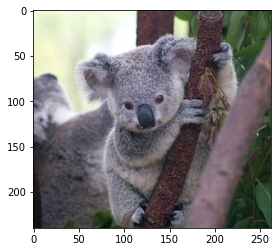

In [8]:
import matplotlib.pyplot as plt
plt.imshow(test_image)

In [9]:
facebook_model.predict(test_image)

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-14.9961,  -0.7040,  -5.5845,  ...,  -9.8785,  -7.7806,   7.8039],
         [-16.2672,  -1.3776,  -8.5474,  ..., -10.4013,  -6.0407,   8.8942],
         [-16.8842,  -0.3447,  -8.1758,  ..., -10.5271,  -7.5120,   8.9979],
         ...,
         [-16.0630,   0.4204,  -5.9730,  ...,  -9.8433,  -6.3353,   8.2324],
         [-17.1253,   1.3350,  -7.1325,  ...,  -9.9052,  -6.2855,   8.9500],
         [-16.7018,  -1.6117,  -7.7396,  ..., -10.5682,  -5.3902,   9.4597]]],
       grad_fn=<AddBackward0>), pred_boxes=tensor([[[0.0215, 0.6321, 0.0430, 0.7224],
         [0.5380, 0.5568, 0.7845, 0.8733],
         [0.3155, 0.6364, 0.6271, 0.7268],
         [0.5237, 0.5584, 0.7993, 0.8742],
         [0.4665, 0.5317, 0.6184, 0.8288],
         [0.5321, 0.5586, 0.8063, 0.8850],
         [0.4879, 0.9526, 0.3580, 0.0945],
         [0.3022, 0.6401, 0.5924, 0.7202],
         [0.1065, 0.4792, 0.2126, 0.4050],
         [0.4438, 0.5012, 0.8892

In [10]:
yolo_model.predict(test_image)

YolosObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-21.5088,  -6.1693, -13.1251,  ..., -11.9608, -10.1007,   1.3124],
         [-26.4495,  -9.7334, -15.5657,  ..., -17.8682, -14.1575,  -1.8353],
         [-24.1169,  -8.9820, -16.1111,  ..., -16.4011, -14.7856,  -0.2207],
         ...,
         [-33.0335, -12.2667, -18.6731,  ..., -22.9309, -12.4346,  -1.5412],
         [-24.8945,  -6.5886, -11.5838,  ..., -17.5700, -11.7855,  -1.0482],
         [-26.9147, -11.9844, -16.8216,  ..., -17.8547, -11.6243,   0.2275]]],
       grad_fn=<AddBackward0>), pred_boxes=tensor([[[0.0114, 0.2288, 0.0231, 0.4404],
         [0.0973, 0.5016, 0.1978, 0.9886],
         [0.0884, 0.5190, 0.1799, 0.4512],
         [0.1509, 0.6353, 0.2994, 0.7260],
         [0.4844, 0.5983, 0.4277, 0.7941],
         [0.5207, 0.4902, 0.6984, 0.7715],
         [0.5392, 0.4081, 0.7639, 0.8016],
         [0.7414, 0.5535, 0.5179, 0.8865],
         [0.4998, 0.9156, 1.0000, 0.1682],
         [0.3987, 0.3295, 0.490

In [11]:
from transformers import pipeline
from PIL import Image, ImageDraw, ImageFont

In [12]:
# Load font
# font = ImageFont.truetype("arial.ttf", 40)

# Initialize the object detection pipeline
object_detector = pipeline("object-detection")

No model was supplied, defaulted to facebook/detr-resnet-50 (https://huggingface.co/facebook/detr-resnet-50)


In [13]:
# Draw bounding box definition
def draw_bounding_box(im, score, label, xmin, ymin, xmax, ymax, index, num_boxes):
    """ Draw a bounding box. """

    print(f"Drawing bounding box {index} of {num_boxes}...")

    # Draw the actual bounding box
    im_with_rectangle = ImageDraw.Draw(im)  
    im_with_rectangle.rounded_rectangle((xmin, ymin, xmax, ymax), outline = "red", width = 5, radius = 10)

    # Draw the label
    im_with_rectangle.text((xmin+35, ymin-25), label, fill="white", stroke_fill = "red")
#     im_with_rectangle.text((xmin+35, ymin-25), label, fill="white", stroke_fill = "red", font = font)

    # Return the intermediate result
    return im

Drawing bounding box 0 of 12...
Drawing bounding box 1 of 12...
Drawing bounding box 2 of 12...
Drawing bounding box 3 of 12...
Drawing bounding box 4 of 12...
Drawing bounding box 5 of 12...
Drawing bounding box 6 of 12...
Drawing bounding box 7 of 12...
Drawing bounding box 8 of 12...
Drawing bounding box 9 of 12...
Drawing bounding box 10 of 12...
Drawing bounding box 11 of 12...


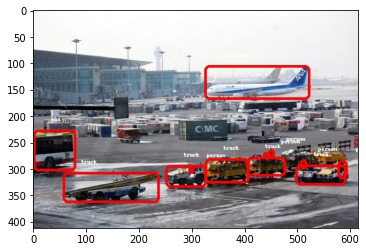

In [14]:
# Open the image
with Image.open("airport.jpeg") as im:

    # Perform object detection
    bounding_boxes = object_detector(im)

    # Iteration elements
    num_boxes = len(bounding_boxes)
    index = 0

    # Draw bounding box for each result
    for bounding_box in bounding_boxes:

        # Get actual box
        box = bounding_box["box"]

        # Draw the bounding box
        im = draw_bounding_box(im, bounding_box["score"], bounding_box["label"],\
            box["xmin"], box["ymin"], box["xmax"], box["ymax"], index, num_boxes)

        # Increase index by one
        index += 1

    plt.imshow(im)